## Importing Libraries

In [87]:
import pandas as pd
import numpy as np
from tabula import read_pdf
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import re
import datetime

## Reading data

In [88]:
hdfc=pd.read_excel('HDFC-15-Aug-21--23-May-22new.xls')

idb=read_pdf('IDBI-15-Aug-21--23-May-22.pdf',output_format='dataframe',pages='all')
idbi=pd.DataFrame(idb[0])

canara=pd.read_csv('Canara-15-Aug-21--23-May-22new.CSV')

sbi=pd.read_excel('SBI-15-Aug-21--23-May-23new.xlsx')

## Preprocessing Data

In [89]:
hdfc.drop(['Value Dt','Chq./Ref.No.'],axis=1,inplace=True)

In [90]:
hdfc.rename(columns={'Narration':'Desc','Withdrawal Amt.':'Debit',
                     'Deposit Amt.':'Credit','Closing Balance':'Balance'},inplace=True)
hdfc['Bank']='HDFC'

In [91]:
idbi.rename(columns={'Unnamed: 1':'Date','Unnamed: 3':'Desc',
                     'Unnamed: 6':'Cr/Dr','Unnamed: 8':'Amount',
                     'Unnamed: 9':'Balance'},inplace=True)

In [92]:
idbi.drop(['Unnamed: 0','Unnamed: 2','Unnamed: 4','Cheque','CC'],axis=1,inplace=True)
idbi['Bank']='IDBI'

In [93]:
canara.rename(columns={'Transaction Date':'Date','Description':'Desc','Balance\t':'Balance'},inplace=True)

In [94]:
canara.drop(['Value Date','Cheque No.','Branch Code'],axis=1,inplace=True)
canara['Bank']='CANARA'

In [95]:
sbi.rename(columns={'Txn Date':'Date','Description':'Desc','        Debit':'Debit'},inplace=True)

In [96]:
sbi.drop(['Value Date','Ref No./Cheque No.'],axis=1,inplace=True)
sbi['Bank']='SBI'

In [97]:
a=0

for a in range(len(sbi.index)):
    date=sbi['Date'].iloc[a]
    if type(date) in [float,str]:
        break
    else:
        sbi['Date'].iloc[a]=date.strftime("%d-%m-%y")
    a+=1

In [98]:
Banks=pd.concat([hdfc,canara,sbi])

### Data Cleaning

In [99]:
def rem_comma(word):
    if type(word)==str:
        i=0
        string=""
        while i<len(word):
            if word[i]!=',':
                string+=word[i]
            i=i+1
        return(string)
    if type(word) in (float,int):
        return word
    else:
        return float("nan") 

In [100]:
Banks['Debit']=Banks['Debit'].apply(rem_comma)
Banks['Credit']=Banks['Credit'].apply(rem_comma)
Banks['Balance']=Banks['Balance'].apply(rem_comma)
idbi['Balance']=idbi['Balance'].apply(rem_comma)
idbi['Amount']=idbi['Amount'].apply(rem_comma)


In [101]:
def conv_num(word):
    if type(word)==str:
        if word[0] in '1 2 3 4 5 6 7 8 9 0 -'.split():
            return float(word)
        else:
            return np.nan
    else:
        return word

In [102]:
idbi['Amount']=idbi['Amount'].apply(conv_num)
idbi['Balance']=idbi['Balance'].apply(conv_num)
Banks['Balance']=Banks['Balance'].apply(conv_num)
Banks['Credit']=Banks['Credit'].apply(conv_num)
Banks['Debit']=Banks['Debit'].apply(conv_num)

In [103]:
idbi=idbi[idbi['Balance'].notna()]
Banks=Banks[Banks['Balance'].notna()]
Banks=Banks[Banks['Desc'].notnull()]

In [104]:
Banks.reset_index(inplace=True,drop=True)

### Converting 'Debit' and 'Credit' column into 'Amount' column

In [105]:
Banks['Amount']=np.nan
a=0

for a in range(Banks['Date'].count()):
    deb=Banks['Debit'].iloc[a]
    cred=Banks['Credit'].iloc[a]
    if pd.notna(deb):
        Banks['Amount'].iloc[a]=deb*(-1)
    else:
        Banks['Amount'].iloc[a]=cred
    a+=1

In [106]:
Banks.drop(['Debit','Credit'],axis=1,inplace=True)

In [107]:
cols=['Date','Desc','Amount','Balance','Bank']
Banks=Banks[cols]

In [108]:
idbi.reset_index(inplace=True,drop=True)

In [109]:
a=0
for a in range(idbi['Date'].count()):
    b=idbi['Cr/Dr'].iloc[a]
    if b=='Dr.':
        idbi['Amount'].iloc[a]*=(-1)
    a+=1

In [110]:
idbi.drop('Cr/Dr',axis=1,inplace=True)

In [111]:
Banks=pd.concat([Banks,idbi])

In [112]:
Banks.reset_index(inplace=True, drop =True)

In [113]:
"""To remove time from idbi transactions for Uniformity"""
a=0

for a in range(Banks['Date'].count()):
    date=Banks['Date'].iloc[a].split()
    if len(b)>1:
        Banks['Date'].iloc[a]=date[0]
    a+=1

### Sorting by Date

In [114]:
Banks['Date']=pd.to_datetime(Banks['Date'],dayfirst=True)

In [115]:
Banks.sort_values(by='Date',inplace=True)
Banks.reset_index(inplace=True,drop=True)

## Data Engineering

### Finding "Person of Interest"(POI)

In [116]:
Banks['POI']='Unknown'
a=0
for a in range(Banks['Date'].count()):
    desc=Banks['Desc'].iloc[a]
    if desc[0:3]=='UPI':
        clues=desc.split('/')
        if len(clues)>3:
            Banks['POI'].iloc[a]=clues[3].lower()
            if clues[6]=='membersh':
                Banks['POI'].iloc[a]='Toastmasters'
    a+=1

In [117]:
POI_idbi=['int.','sms','ganesh','kripa','refund','petroleum','donot','cash','cardfee','kfc']
POI_sbi=['avenues','bsnl','apy','thathanatt','fortune','medicalcentrernakulam','interest','sudeendhra','amazon',
         'teekoy','fruits','bulk','9447375729','p2a','boutiqernakulam','fuels','atm','more','pavilion','makemytrip',
         'ganesh','iit','irctc','bigtree','refund','sbilt']
POI_hdfc=['ganeshmohan','navaratna','interest','ganesh','p2p','fee','nwd','midhun','hospital','thathanatt']
POI_canara=['google','charges','ib','netflix','canva','amazonpayindiapriva','sbint','netflixentertainment',
            'ganeshmoha','wwwamazonin','googleplaymumbaiin','googleyoutubepremium','ecs','ibpsmumbaiin','ganesh']

In [118]:
"""POI assignation"""
a=0
for a in range(Banks['Date'].count()):
    bank=Banks['Bank'].iloc[a]
    desc=Banks['Desc'].iloc[a]
    poi=Banks['POI'].iloc[a]
    clues=re.split('-|_|/| |:',desc)
    if bank=='IDBI':
        b=0
        for b in range(len(clues)):
            if clues[b].lower() in POI_idbi:
                Banks['POI'].iloc[a]=clues[b].lower()
                break
            b+=1
    if bank=='SBI':
        b=0
        for b in range(len(clues)):
            if clues[b].lower() in POI_sbi:
                Banks['POI'].iloc[a]=clues[b].lower()
                break
            b+=1
    if bank=='HDFC':
        b=0
        for b in range(len(clues)):
            if clues[b].lower() in POI_hdfc:
                Banks['POI'].iloc[a]=clues[b].lower()
                break
            b+=1
    if (bank=='CANARA')and(poi=='Unknown'):
        b=0
        for b in range(len(clues)):
            if clues[b].lower() in POI_canara:
                Banks['POI'].iloc[a]=clues[b].lower()
                break
            b+=1
    
    a+=1

In [119]:
"""The rest of the POI for sbi and canara"""
a=0
for a in range(Banks['Date'].count()):
    bank=Banks['Bank'].iloc[a]
    desc=Banks['Desc'].iloc[a]
    poi=Banks['POI'].iloc[a]
    clues1=re.split('1|2|3|4|5|6|7|8|9|0| |-|,',desc)
    clues2=desc.split('*')
    clues3=desc.split('(')
    if poi=='Unknown':
        b=0
        for b in range(len(clues1)):
            if clues1[b].lower() in POI_sbi+POI_canara:
                Banks['POI'].iloc[a]=clues1[b].lower()
                break
            b+=1
        b=0
        for b in range(len(clues2)):
            clues=re.split('1|2|3|4|5|6|7|8|9|0| |-|,',clues2[b])
            c=0
            for c in range(len(clues)):
                if clues[c].lower() in POI_sbi+POI_canara:
                    Banks['POI'].iloc[a]=clues[c].lower()
                    break
                c+=1
            b+=1
        b=0
        for b in range(len(clues3)):
            clues=clues3[b].split()
            c=0
            for c in range(len(clues)):
                if clues[c].lower() in POI_sbi+POI_canara:
                    Banks['POI'].iloc[a]=clues[c].lower()
                    break
                c+=1
            b+=1
    a+=1        

### Removing duplicates in POI

In [120]:
"""Multiple names"""
a=0
for a in range(Banks['Date'].count()):
    poi=Banks['POI'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    if poi in ['ib','ganeshmohan','dummy name','9447375729','p2a','ganesh','ganeshmoha']:
        Banks['POI'].iloc[a]='Ganesh'
    if poi in ['aashishla','aashish  ']:
        Banks['POI'].iloc[a]='Aashish'
    if poi in ['geetha  c','sbilt','geetha c ']:
        Banks['POI'].iloc[a]='Amma'
    if poi in ['srikanth ']:
        Banks['POI'].iloc[a]='Srikanth'
    if poi in ['amal  c s']:
        Banks['POI'].iloc[a]='Amal C'
    if poi in ['netflix','netflixentertainment']:
        Banks['POI'].iloc[a]='netflix'
    if poi in ['emmanuel ','emmanuelb']:
        Banks['POI'].iloc[a]='Emmanuel'
    if poi in ['sreejith ']:
        if amt<-100:
            Banks['POI'].iloc[a]='Sreejith-Ril'
        else:
            Banks['POI'].iloc[a]='Sreejith'
    if poi in ['midhun k','midhun']:
        Banks['POI'].iloc[a]='Midhun'
    if poi in ['rahul jay']:
        Banks['POI'].iloc[a]='Rahul J'
    if poi in ['uthara  t','amal  p t']:
        Banks['POI'].iloc[a]='Amal PT'
    if poi in ['arjun  ma']:
        Banks['POI'].iloc[a]='Arjun Maku'
    if poi in ['vishnu vi','vishnu.vi']:
        Banks['POI'].iloc[a]='Vishnu V'
    if poi in ['mahesh mo']:
        Banks['POI'].iloc[a]='Mahesh'
    if poi in ['mr athul ','athul joh']:
        Banks['POI'].iloc[a]='Athul'
    if poi in ['googleyoutubepremium','google']:
        Banks['POI'].iloc[a]='Youtube'
    if poi in ['harikrish','790230715']:
        Banks['POI'].iloc[a]='Hari TS'
    if poi in ['bibin  jo','bibin john']:
        Banks['POI'].iloc[a]='Bibin'
    if poi in ['amazon','amazonpayindiapriva','wwwamazonin']:
        Banks['POI'].iloc[a]='amazon'
    if poi in ['razorpaya','bharti ai']:
        Banks['POI'].iloc[a]='Airtel'
    if poi in ['thesreera','sreerag p']:
        Banks['POI'].iloc[a]='sreerag p'
    a+=1

### Finding Sub-Categories

In [121]:
SNVP=['Aashish','Srikanth','Midhun','Rahul J', 'sreeraj r','Hari TS','srinath r', 'Amal PT','p vinayak','Vishnu V',
      'amal p j', 'kiran k s','vishnu t ','sreenath ','prashob p','Sreejith']
Friends=['Amal C','Emmanuel','Sreejith-Ril','Arjun Maku','dharmendr','jnananshu','sreerag p', 'Athul', 'anjita n a',
         'arya leks','hitesh ta', 'rahul  s','Mahesh','sam satya']
pump=['thathanatt','fortune','k p vargh','hp petrol','kripa','kripa fue','teekoy','kp varghe','petroleum','thathanat',
      'fuels','sasikumar','st thomas','raju ente','sterling ','io851683.']
med=['medicalcentrernakulam','canva','sudeendhra', 'new st ma', 'ashraya m','doctors d','maria med','sevana me',
     'netambit','alfaone r','mr. shaji','hospital','thripunit']
foods=['taste   t','taste   t','binu r','k s sasi','Bibin','rajadhani','swiggy','manikutta','rafeek ar','aby tom n',
       'donot','chempakam','ashraf ah','alma bake','hitachi p','abraham p','amani ear']
stores=['sree kuma', 'venu  m  n', 'pulimoott', 'aiswarya ', 'edathileg', 'edathil e', 'easyday', 'muhammed',
        'prime sup', 'sobhaslad','dressworld', 'merrina a', 'biju k k', 'boutiqernakulam', 'bharatpem', 
        'bharatpe.', 'fruits', 'more,', 'p k shefi','saimy geo', 'k s joseph','more','krishna  ','zgraphics',
        'mariyam x','muhammed ','siraj  my','priyom ma','paris col','down town','safiyat h','h and c s']

In [122]:
"""Sub-Categories"""
Banks['SubC']='Unknown'
a=0
for a in range(Banks['Date'].count()):
    poi=Banks['POI'].iloc[a]
    if poi in ['sms','kfc','cardfee','charges','navaratna','p2p','fee']:
        Banks['SubC'].iloc[a]='Charges'
    if poi in ['int.','googlepay','bulk','interest','sbint']:
        Banks['SubC'].iloc[a]='Interest'
    if poi in ['avenues','reliance ']:
        Banks['SubC'].iloc[a]='Jio'
    if poi in ['Youtube','netflix']:
        Banks['SubC'].iloc[a]='TV'
    if poi in ['Ganesh']:
        Banks['SubC'].iloc[a]='Fund Transfer'
    if poi in SNVP:
        Banks['SubC'].iloc[a]='SNVP'
    if poi in ['bsnl','Airtel']:
        Banks['SubC'].iloc[a]='Mobile'
    if poi in ['Amma']:
        Banks['SubC'].iloc[a]='Amma'
    if poi in Friends:
        Banks['SubC'].iloc[a]='Friends'
    if poi in ['apy']:
        Banks['SubC'].iloc[a]='APY'
    if poi in ['kiran s','unnikrish','iva sports','anusree  p','k s moham','pavilion']:
        Banks['SubC'].iloc[a]='Badminton'
    if poi in ['kotha sri']:
        Banks['SubC'].iloc[a]='Haircut'
    if poi in pump:
        Banks['SubC'].iloc[a]='Petrol'
    if poi in med or poi=='dunzo dig':
        Banks['SubC'].iloc[a]='Meds'
    if poi in ['neelatt g','bhasura v']:
        Banks['SubC'].iloc[a]='Fund'
    if poi in ['amazon','googleplaymumbaiin']:
        Banks['SubC'].iloc[a]='Online'
    if poi in ['razorpay','ibpsmumbaiin']:
        Banks['SubC'].iloc[a]='Exam'
    if poi in foods:
        Banks['SubC'].iloc[a]='Food'
    if poi in stores:
        Banks['SubC'].iloc[a]='Purchase'
    if poi in ['bigtree e', 'bigtree', 'v s ventu']:
        Banks['SubC'].iloc[a]='Movie'
    if poi in ['althaf v s', 'shameer  ']:
        Banks['SubC'].iloc[a]='Trip'
    if poi in ['bullet pa', 'suresh ku', 'smooth ri','mangalath']:
        Banks['SubC'].iloc[a]='Vehicle'
    if poi in ['makemytrip', 'olacabs', 'yatra','irctc','refund','ibibo gro']:
        Banks['SubC'].iloc[a]='Travel'
    if poi in ['ecs','iit']:
        Banks['SubC'].iloc[a]='Income'
    if poi in ['cash','atm','nwd']:
        Banks['SubC'].iloc[a]='Cash'
    if poi in ['astro 7 s']:
        Banks['SubC'].iloc[a]='Football'
    if poi in ['ajay  p a','jayesh b k','sylviya s','Toastmasters']:
        Banks['SubC'].iloc[a]='Others'
    a+=1

### Finding Reasons for FRIENDS AND FAMILY transfers

In [123]:
"""Reasons for FRIENDS AND FAMILY transfers """
Banks['why']='Unknown'
a=0
for a in range(Banks['Date'].count()):
    subc=Banks['SubC'].iloc[a]
    if subc!='Friends' and subc!='SNVP' and subc!='Amma':
        Banks['why'].iloc[a]='Known'
    a+=1

In [124]:
a=0
for a in range(Banks['Date'].count()):
    desc=Banks['Desc'].iloc[a]
    why=Banks['why'].iloc[a]
    if (why=='Unknown')and(desc[0:3]=='UPI'):
        clue=desc.split('/')[6]
        Banks['why'].iloc[a]=clue
    a+=1

In [125]:
why_badmin=['badminton','sreeraj ','badminto','shuttle','sat badm','bat','hbat','batmi','iSports','Aashish ','oct 31st',
            'new year']
why_food=['snacks', 'dinner', 'pachola','kitkat c','food','cake', 'dosai', 'shake','LMN','nettoor ','brindhavan',
          'french t','Pappaya ','pappaya', 'poem cafe', 'food ekm','cool cool','NM lunch','biriyani','lunch ve', 
          'Dinner','Chinnu h','me and n','NO REMARKS']

In [126]:
a=0
for a in range(Banks['Date'].count()):
    why=Banks['why'].iloc[a]
    poi=Banks['POI'].iloc[a]
    if why in why_badmin:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Badminton'
    if why in why_food:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Food'
    if why in ['Wagamon','trip','Tour','vagamon ','Goa trip','Varkala ','trip cash']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Trip'
    if why in ['gift','Me and A','gifts','Gift for','gift share','Kamath g','ashish']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Gift'
    if why in ['diary pu','fruits f','glass']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Purchase'
    if why in ['football']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Football'
    if why in ['petrol','petrol b', 'fuel tvm']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Petrol'
    if why in ['film','film cash','bheeshma']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Movie'
    if why in ['medicines','meds','t','meds and','medical ']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Meds'
    if why in ['lending','tinder','repayment']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Loan'
    if why in ['Unknown'] and poi=='Midhun':
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Loan'  
    if why in ['Unknown'] and poi=='Amma':
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Fund'
    if why in ['car fast'] and poi=='Amma':
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Vehicle'
    if why in ['cash']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Cash'
    if why in ['Netflix ','nov dec ','netflix']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='TV'
    if why in ['cashback', 'test pas','test']:
        Banks['why'].iloc[a]='Known'
        Banks['SubC'].iloc[a]='Interest'
    a+=1

In [127]:
Badminton=['Aashish','Srikanth','Midhun','Rahul J', 'sreeraj r','Hari TS','srinath r', 'p vinayak',
              'Vishnu V', 'amal p j', 'kiran k s','vishnu t ','sreenath ','Sreejith']

In [128]:
"""SPORTS DATES WHEN I PAID"""
a=0
for a in range(Banks['Date'].count()):
    poi=Banks['POI'].iloc[a]
    date=Banks['Date'].iloc[a]
    if poi in ['kiran s','anusree  p','astro 7 s']:
        Dates=[date+datetime.timedelta(i) for i in range(6)]
        b=0
        for b in range(a-20,615):
            amt=Banks['Amount'].iloc[b]
            poi=Banks['POI'].iloc[b]
            why=Banks['why'].iloc[b]
            date=Banks['Date'].iloc[b]
            if (why!='Known')and(date in Dates)and(poi in Badminton)and(amt>0)and(amt<400):
                Banks['why'].iloc[b]='Known'
                Banks['SubC'].iloc[b]='Badminton'
            b+=1
    a+=1   

### Using additional data

In [129]:
"""Based on data from Gpay"""
Banks=Banks.append(Banks[Banks['Amount']==-920]) 
Banks=Banks.append(Banks[Banks['Amount']==1750])
Banks.sort_values(by='Date',inplace=True)
Banks.reset_index(inplace=True,drop=True)

count1=0
count2=0
a=0
for a in range(Banks['Date'].count()):
    amt=Banks['Amount'].iloc[a]
    poi=Banks['POI'].iloc[a]
    date=Banks['Date'].iloc[a]
    if amt==-920:
        if count1==0:
            Banks['Amount'].iloc[a]=-500
            Banks['Balance'].iloc[a]=2420.71
            Banks['SubC'].iloc[a]='Gift'
            count1+=1
        else:
            Banks['Amount'].iloc[a]=-420
            Banks['SubC'].iloc[a]='Meds'
        Banks['why'].iloc[a]='Known'
    if amt==1750:
        if count2==0:
            Banks['Amount'].iloc[a]=1500
            Banks['Balance'].iloc[a]=2670.71
            Banks['SubC'].iloc[a]='Loan'
            count2+=1
        else:
            Banks['Amount'].iloc[a]=250
            Banks['SubC'].iloc[a]='TV'
        Banks['why'].iloc[a]='Known'
    if amt in [-231,-164]:
        Banks['SubC'].iloc[a]='Food'
        Banks['why'].iloc[a]='Known'
    if poi=='Sreejith-Ril':
        Banks['SubC'].iloc[a]='Gift'
        Banks['why'].iloc[a]='Known'
    if poi=='Hari TS' and date==pd.to_datetime('2021-10-13') and why!='Known':
        Banks['SubC'].iloc[a]='Trip'
        Banks['why'].iloc[a]='Known'
    if poi=='Amma' and date==pd.to_datetime('2021-10-29') and why!='Known':
        Banks['SubC'].iloc[a]='Meds'
        Banks['why'].iloc[a]='Known'
    a+=1

In [130]:
"""Purchase dates"""
sponsor=['Amma','bhasura v']
a=0
for a in range(Banks['Date'].count()):
    date=Banks['Date'].iloc[a]
    subc=Banks['SubC'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    if subc in ['Travel','Petrol','Jio'] and amt<=-400:
        Date=date
        Amt=round(amt*(-1))
        b=0
        for b in range(Banks['Date'].count()):
            date=Banks['Date'].iloc[b]
            poi=Banks['POI'].iloc[b]
            amt=Banks['Amount'].iloc[b]
            if date==Date and poi in ['Amma'] and amt>=Amt:
                Banks['SubC'].iloc[b]=subc
                Banks['why'].iloc[b]='Known'
            b+=1
    if subc in ['Purchase','Cash'] and amt<=-1000:
        Date=date
        b=0
        for b in range(Banks['Date'].count()):
            date=Banks['Date'].iloc[b]
            poi=Banks['POI'].iloc[b]
            if date==Date and poi in ['Amma','nwd'] :
                Banks['SubC'].iloc[b]='Purchase'
                Banks['why'].iloc[b]='Known'
            b+=1
    if subc in ['Movie'] and amt<-500:
        Dates=[date+datetime.timedelta(i) for i in range(5)]
        Amt=round(amt*(-1))
        b=0
        for b in range(Banks['Date'].count()):
            date=Banks['Date'].iloc[b]
            poi=Banks['POI'].iloc[b]
            amt=Banks['Amount'].iloc[b]
            if date in Dates and poi in sponsor and amt in range(Amt,Amt+30):
                Banks['SubC'].iloc[b]='Movie'
                Banks['why'].iloc[b]='Known'
            b+=1
    a+=1  

In [131]:
"""Loan Group"""
Badmi_start=pd.to_datetime('2021-09-20')
a=0
for a in range(Banks['Date'].count()):
    poi=Banks['POI'].iloc[a]
    why=Banks['why'].iloc[a]
    date=Banks['Date'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    if poi in ['Amal C','Arjun Maku','dharmendr','jnananshu','Athul'] and why!='Known':
        Banks['SubC'].iloc[a]='Loan'
        Banks['why'].iloc[a]='Known'
    if poi in ['Aashish','Srikanth'] and why!='Known' and date<Badmi_start:
        Banks['SubC'].iloc[a]='Loan'
        Banks['why'].iloc[a]='Known'
    if poi in ['Hari TS'] and why!='Known' and amt>500:
        Banks['SubC'].iloc[a]='Loan'
        Banks['why'].iloc[a]='Known'
    a+=1

In [132]:
"""Movie days"""
Dates=pd.to_datetime(['2021-12-27','2022-03-10','2022-05-16'])
Date=pd.to_datetime('2022-03-11')
movie_guys=['Aashish','anjita n a','Vishnu V']
a=0
for a in range(Banks['Date'].count()):
    why=Banks['why'].iloc[a]
    date=Banks['Date'].iloc[a]
    poi=Banks['POI'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    if date in Dates and why!='Known' and poi in movie_guys:
        Banks['SubC'].iloc[a]='Movie'
        Banks['why'].iloc[a]='Known'
    if date==Date and (amt<-300) and why!='Known' and poi in movie_guys:
        Banks['SubC'].iloc[a]='Movie'
        Banks['why'].iloc[a]='Known'
    a+=1

In [133]:
"""Gift days"""
Aash_bday=pd.to_datetime('2021-11-01')
Abhi_bday=pd.to_datetime('2022-03-26')
Chechi_bday=pd.to_datetime('2021-12-09')
Mah_bday=pd.to_datetime('2021-09-22')
PTvava_bday=pd.to_datetime('2022-05-22')
AmalC_gift=pd.to_datetime('2021-10-02')
Rahul_gift=[pd.to_datetime('2022-01-14')+datetime.timedelta(i) for i in range(3)]

Family=['Aashish','anjita n a','Mahesh']
Bday=[Aash_bday,Abhi_bday,Chechi_bday,Mah_bday]

Gift_day=[]
for day in Bday:
    for i in range(7):
        Gift_day.append(day-datetime.timedelta(i))
        i+=1
Gift_day.append(AmalC_gift)

a=0
for a in range(Banks['Date'].count()):
    date=Banks['Date'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    poi=Banks['POI'].iloc[a]
    subc=Banks['SubC'].iloc[a]
    if date in Gift_day and (amt>500 or amt<-500) and (poi in Family or subc=='Online'):
        Banks['SubC'].iloc[a]='Gift'
        Banks['why'].iloc[a]='Known'
    if date == PTvava_bday and (amt==-100):
        Banks['SubC'].iloc[a]='Gift'
        Banks['why'].iloc[a]='Known'
    if date in Rahul_gift and (poi=='hitesh ta' or subc=='Online'):
        Banks['SubC'].iloc[a]='Gift'
        Banks['why'].iloc[a]='Known'
    a+=1

In [134]:
"""From Memory"""
a=0
for a in range(617):
    date=Banks['Date'].iloc[a]
    why=Banks['why'].iloc[a]
    poi=Banks['POI'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    if (date == pd.Timestamp('2022-05-21')):
        if (why!='Known'):
            Banks['SubC'].iloc[a]='Food'
            Banks['why'].iloc[a]='Known'
    if (date == pd.Timestamp('2022-03-11')):
        if (why!='Known') and poi=='anjita n a':
            Banks['SubC'].iloc[a]='Gift'
            Banks['why'].iloc[a]='Known'
    if (poi=='Vishnu V') and (amt>=200 or amt <=-200):
        if (why!='Known'):
            Banks['SubC'].iloc[a]='Meds'
            Banks['why'].iloc[a]='Known'
    if (date == pd.Timestamp('2022-03-11')):
        if (poi in ['sylviya s','irctc']):
            Banks['SubC'].iloc[a]='Trip'
            Banks['why'].iloc[a]='Known'
    if (date == pd.Timestamp('2021-10-04')):
        if (poi=='Amal PT'):
            Banks['SubC'].iloc[a]='Food'
            Banks['why'].iloc[a]='Known'
    a+=1

In [135]:
"""Badminton Group"""
a=0
for a in range(Banks['Date'].count()):
    poi=Banks['POI'].iloc[a]
    why=Banks['why'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    if (poi in Badminton) and (why!= 'Known'):
        Banks['SubC'].iloc[a]='Badminton'
        Banks['why'].iloc[a]='Known'
    if poi=='sreerag p' and amt==150:
        Banks['SubC'].iloc[a]='Badminton'
        Banks['why'].iloc[a]='Known'
    a+=1

In [136]:
"""Netflix Group"""
Netflix=['sreerag p','hitesh ta','Emmanuel','anjita n a']
a=0
for a in range(Banks['Date'].count()):
    poi=Banks['POI'].iloc[a]
    why=Banks['why'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    if poi in Netflix and why!='Known':
        if amt<-2000:
            Banks['SubC'].iloc[a]='Loan'
        else:
            Banks['SubC'].iloc[a]='TV'
        Banks['why'].iloc[a]='Known'

In [137]:
"""Cash from Amma"""
a=0
for a in range(Banks['Date'].count()):
    poi=Banks['POI'].iloc[a]
    why=Banks['why'].iloc[a]
    if poi=='Amma' and why!='Known':
        Banks['SubC'].iloc[a]='Cash'
        Banks['why'].iloc[a]='Known'
    a+=1

In [138]:
Banks.drop(['Desc','why'],axis=1,inplace=True)

### Finding Main Categories

In [139]:
"""Main Categories"""
Banks['Cats']='Unknown'
a=0

for a in range(Banks['Date'].count()):
    subc=Banks['SubC'].iloc[a]
    if subc in ['Football','Badminton']:
        Banks['Cats'].iloc[a]='Sports'
    if subc in ['Movie','Trip','TV','Haircut']:
        Banks['Cats'].iloc[a]='Luxury'
    if subc in ['Online','Purchase']:
        Banks['Cats'].iloc[a]='Purchase'
    if subc in ['Exam','Vehicle','Mobile','APY','Others','Jio','Travel']:
        Banks['Cats'].iloc[a]='Expense'
    if subc in ['Friends','SNVP']:
        Banks['Cats'].iloc[a]='Friends'
    if subc in ['Interest','Charges','Fund Transfer']:
        Banks['Cats'].iloc[a]='Banks'
    if subc in ['Fund','Income']:
        Banks['Cats'].iloc[a]='Income'
    a+=1

In [140]:
a=0
for a in range(Banks['Date'].count()):
    subc=Banks['SubC'].iloc[a]
    cat=Banks['Cats'].iloc[a]
    if cat=='Unknown':
        Banks['Cats'].iloc[a]=subc
    a+=1

## EDA

In [141]:
Banks['Cats'].value_counts()

Sports      147
Banks        85
Luxury       68
Food         63
Expense      52
Purchase     51
Meds         44
Loan         34
Petrol       33
Gift         20
Cash         14
Income        6
Name: Cats, dtype: int64

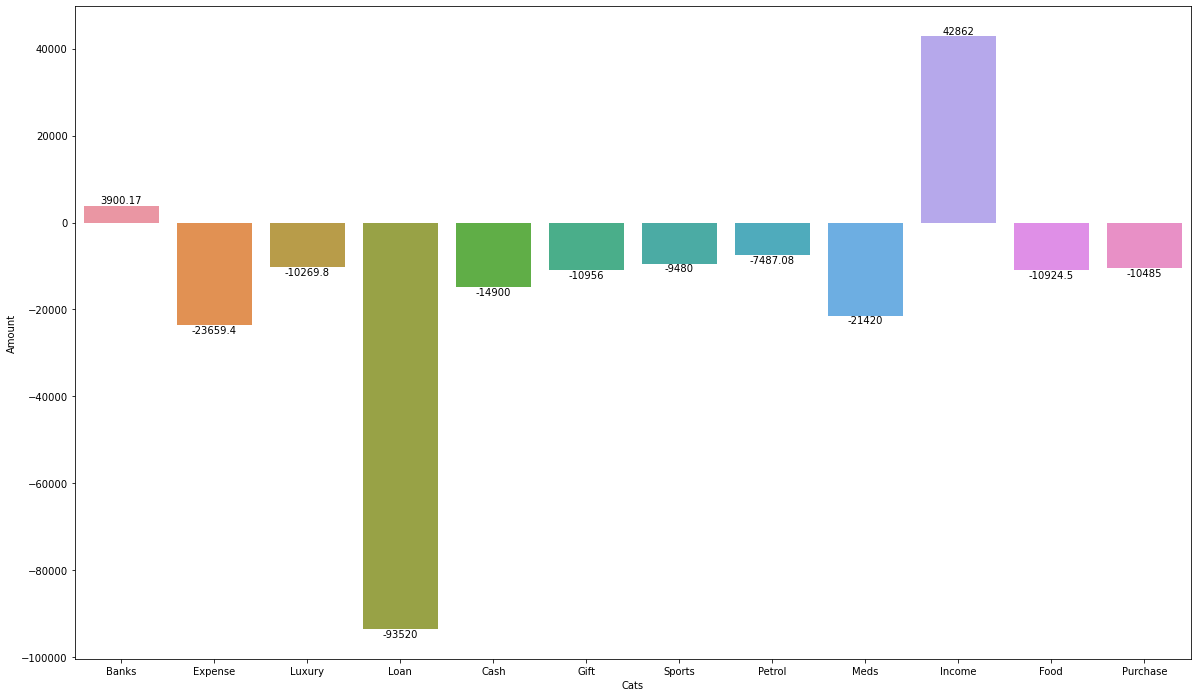

In [142]:
plt.figure(figsize=(20,12))
ax=sns.barplot(data=Banks, x='Cats',y='Amount',estimator=sum,ci=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig('Finances.png')

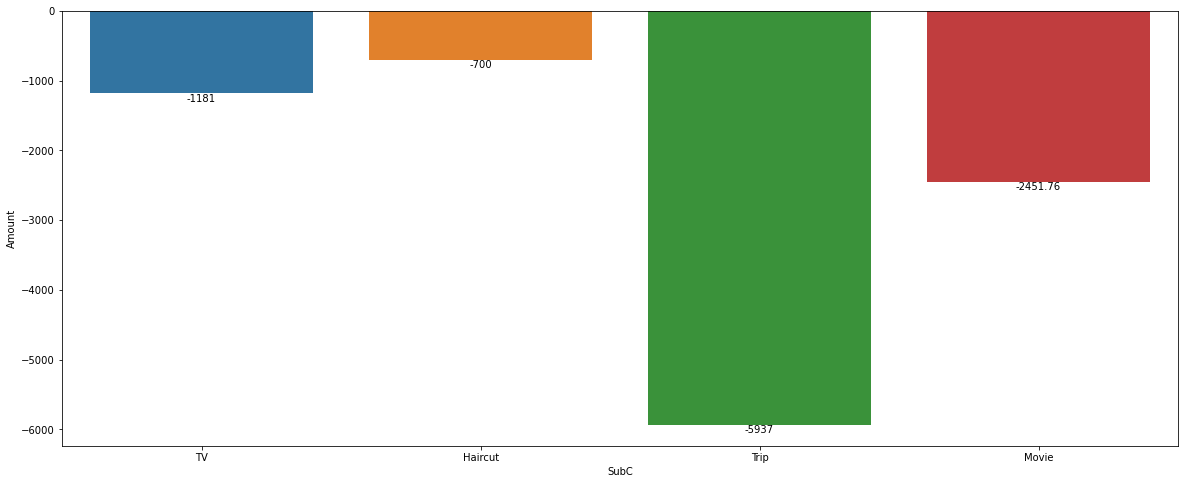

In [143]:
plt.figure(figsize=(20,8))
ax=sns.barplot(data=Banks[Banks['Cats']=='Luxury'], x='SubC',y='Amount',estimator=sum,ci=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig('Luxury.png')

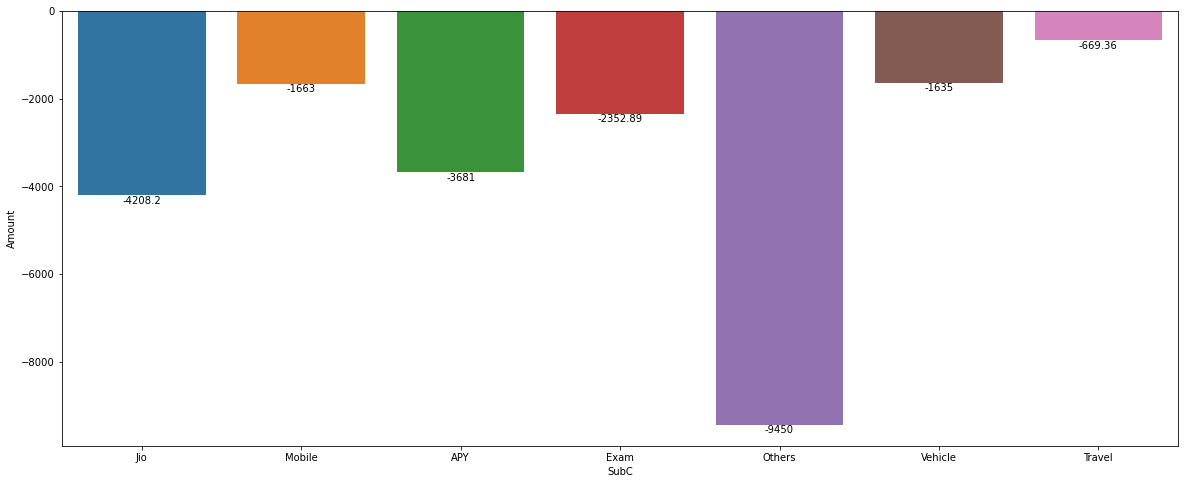

In [144]:
plt.figure(figsize=(20,8))
ax=sns.barplot(data=Banks[Banks['Cats']=='Expense'], x='SubC',y='Amount',estimator=sum,ci=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig('Expenses.png')

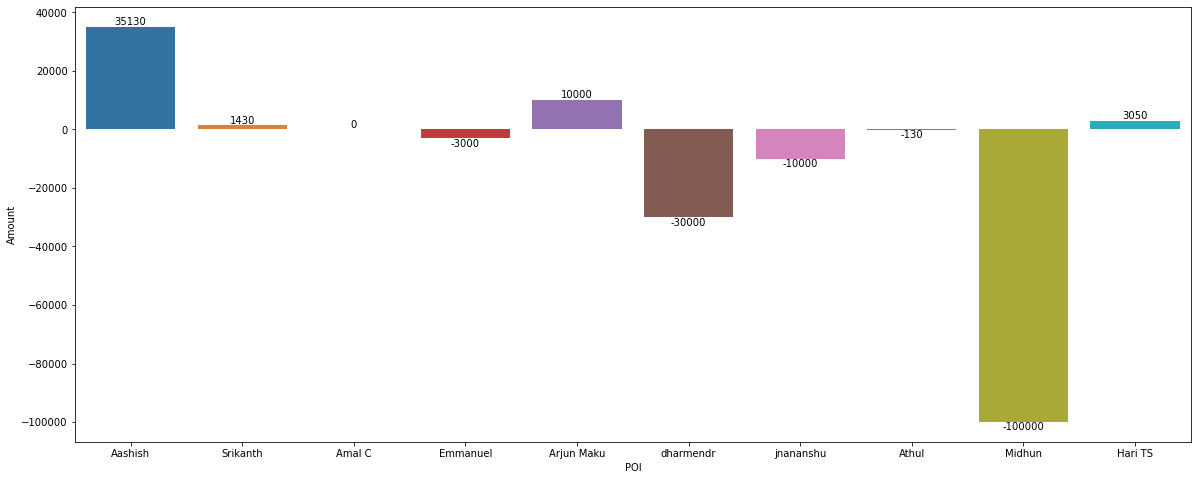

In [145]:
plt.figure(figsize=(20,8))
ax=sns.barplot(data=Banks[Banks['Cats']=='Loan'], x='POI',y='Amount',estimator=sum,ci=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig('Loan.png')

In [146]:
Banks['Rslt']='Unknown'
a=0
for a in range(Banks['Date'].count()):
    cats=Banks['Cats'].iloc[a]
    if cats=='Loan':
        Banks['Rslt'].iloc[a]='Loan'
    elif cats in ['Income','Banks']:
        Banks['Rslt'].iloc[a]='Revenue'
    else:
        Banks['Rslt'].iloc[a]='Expend'
    a+=1

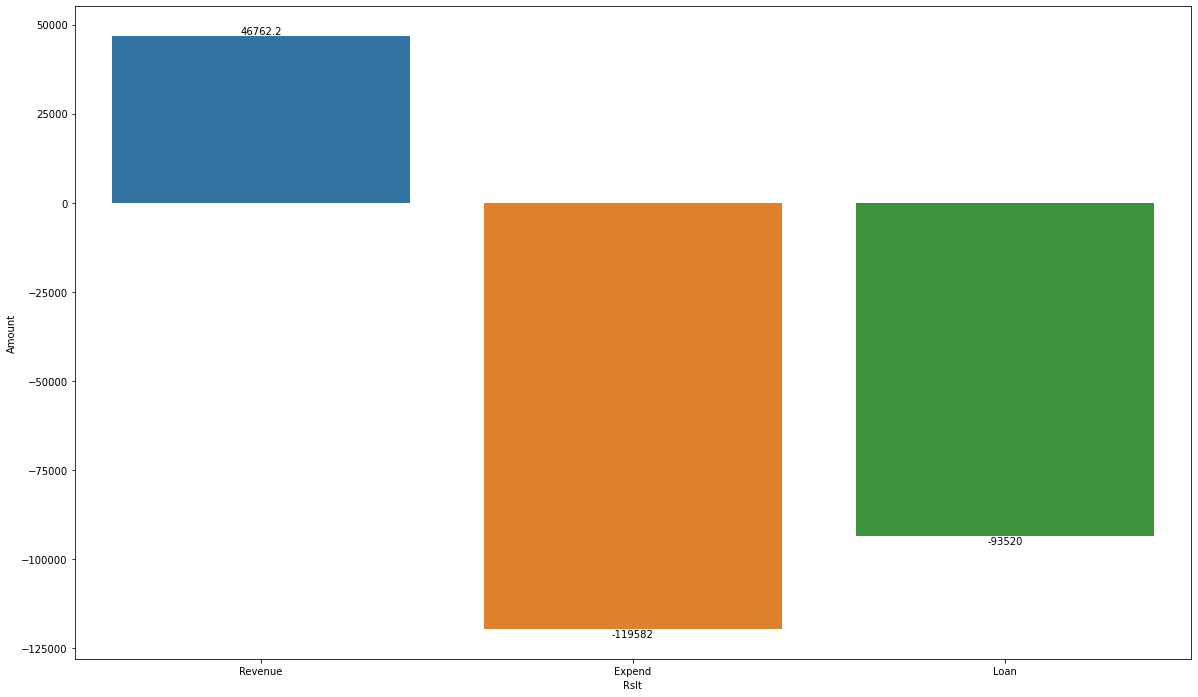

In [147]:
plt.figure(figsize=(20,12))
ax=sns.barplot(data=Banks, x='Rslt',y='Amount',estimator=sum,ci=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig('Result.png')

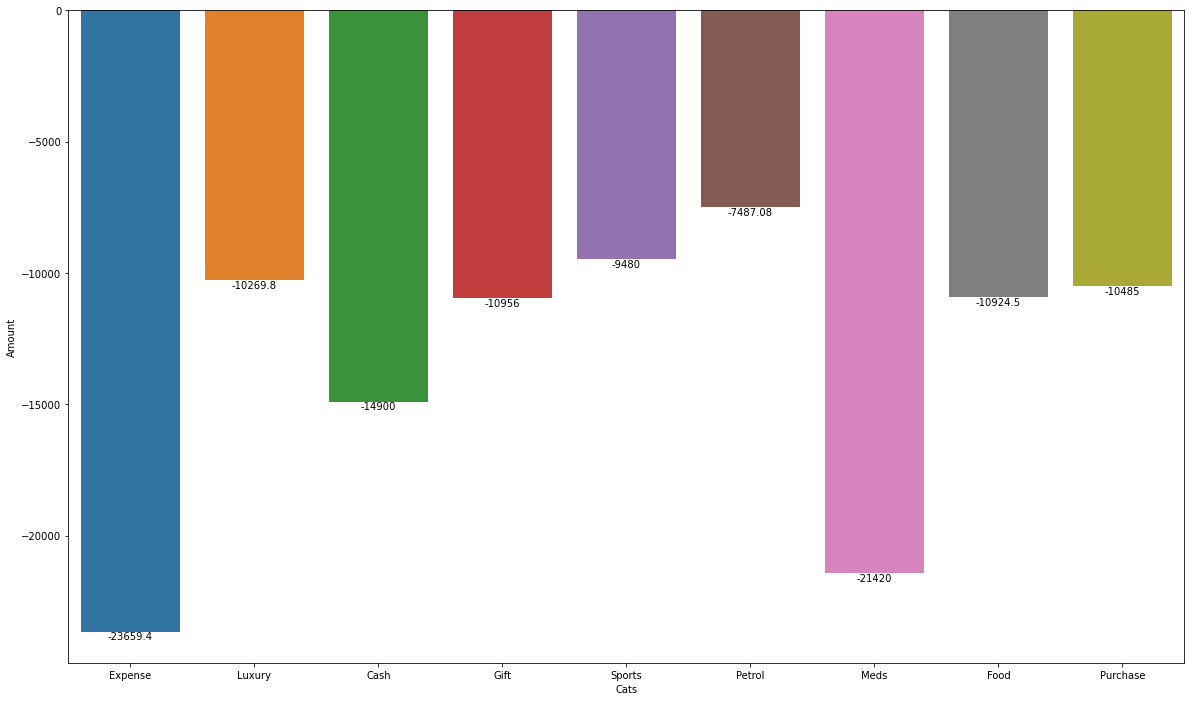

In [148]:
plt.figure(figsize=(20,12))
ax=sns.barplot(data=Banks[Banks['Rslt']=='Expend'], x='Cats',y='Amount',estimator=sum,ci=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.savefig('Expenditure.png')

## Summary

In [149]:
a=0 
ini_idbi=0
ini_can=0
ini_sbi=0
ini_hdfc=0
Date=0
last=0
for a in range(Banks['Date'].count()):
    bank=Banks['Bank'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    date=Banks['Date'].iloc[a]
    Bal=Banks['Balance'].iloc[a]
    if bank=='CANARA' and ini_can==0:
        ini_can=round(Bal-amt,2)
        Date=date
    if date==Date and bank=='CANARA':
        ini_can=round(Bal-amt,2)
    if bank=='IDBI' and ini_idbi==0:
        ini_idbi=round(Bal-amt,2)
    if bank=='HDFC' and ini_hdfc==0:
        ini_hdfc=round(Bal-amt,2)
    if bank=='SBI' and ini_sbi==0:
        ini_sbi=round(Bal-amt,2)
    if bank=='CANARA':
        if last==0:
            fin_can=Bal
            last=date
        elif date!=last:
            fin_can=Bal
            last=date
        else:
            if Bal<fin_can:
                fin_can=Bal
    if bank=='IDBI':
        fin_idbi=Bal
    if bank=='HDFC':
        fin_hdfc=Bal
    if bank=='SBI':
        fin_sbi=Bal
    a+=1
ini_bal=ini_can+ini_sbi+ini_hdfc+ini_idbi
fin_bal=fin_can+fin_sbi+fin_hdfc+fin_idbi
print("CANARA :\nInitial Balance:  Rs{} \nFinal Balance:  Rs{}\nSpend:  {}".format(ini_can,fin_can,ini_can-fin_can))
print("IDBI :\nInitial Balance:  Rs{} \nFinal Balance:  Rs{}\nSpend:  {}".format(ini_idbi,fin_idbi,round(ini_idbi-fin_idbi,2)))
print("SBI :\nInitial Balance:  Rs{} \nFinal Balance:  Rs{}\nSpend:  {}".format(ini_sbi,fin_sbi,ini_sbi-fin_sbi))
print("HDFC :\nInitial Balance:  Rs{} \nFinal Balance:  Rs{}\nSpend:  {}".format(ini_hdfc,fin_hdfc,round(ini_hdfc-fin_hdfc,2)))
print("Total :\nInitial Balance:  Rs{} \nFinal Balance:  Rs{}\nSpend:  {}".format(ini_bal,fin_bal,round(ini_bal-fin_bal,2)))

CANARA :
Initial Balance:  Rs94839.28 
Final Balance:  Rs2442.36
Spend:  92396.92
IDBI :
Initial Balance:  Rs13208.05 
Final Balance:  Rs3042.88
Spend:  10165.17
SBI :
Initial Balance:  Rs9997.43 
Final Balance:  Rs28528.91
Spend:  -18531.48
HDFC :
Initial Balance:  Rs123776.3 
Final Balance:  Rs41467.29
Spend:  82309.01
Total :
Initial Balance:  Rs241821.06 
Final Balance:  Rs75481.44
Spend:  166339.62


In [150]:
a=0 
tot_idbi=0
tot_can=0
tot_sbi=0
tot_hdfc=0
for a in range(Banks['Date'].count()):
    bank=Banks['Bank'].iloc[a]
    amt=Banks['Amount'].iloc[a]
    if bank=='CANARA':
        tot_can+=amt
    if bank=='SBI':
        tot_sbi+=amt
    if bank=='IDBI':
        tot_idbi+=amt
    if bank=='HDFC':
        tot_hdfc+=amt
    a+=1
tot=tot_sbi+tot_can+tot_idbi+tot_hdfc
print('CANARA: Rs.{}'.format(round(tot_can*-1,2)))
print('IDBI: Rs.{}'.format(round(tot_idbi*-1,2)))
print('SBI: Rs.{}'.format(round(tot_sbi*-1,2)))
print('HDFC: Rs.{}'.format(round(tot_hdfc*-1,2)))
print('TOTAL: Rs.{}'.format(round(tot*-1,2)))

CANARA: Rs.92396.92
IDBI: Rs.10165.17
SBI: Rs.-18531.48
HDFC: Rs.82309.01
TOTAL: Rs.166339.62
